In [6]:
from numba.cpython.slicing import slice_indices
%reload_ext autoreload
%autoreload 2

from lib.formatting import bitstring_to_int
from lib.data_loading import load_measurements, MixedDataLoader
from lib.state_io import load_state_vector

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence, Callable

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
from jax.random import PRNGKey
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn
from jaxtyping import PyTree

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506131953_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506131953_0


In [25]:
class ConditionalRBM(nn.Module):
    num_visible: int
    num_hidden: int
    conditioner_width: int = 64
    k: int = 1
    T: float = 1.0

    def setup(self):
        # we use frozen RBM parameters
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W = self.variable("rbm", "W", zeros, (self.num_visible, self.num_hidden))
        self.b = self.variable("rbm", "b", zeros, (self.num_visible,))   # global init
        self.c = self.variable("rbm", "c", zeros, (self.num_hidden,))    # global init

    @nn.compact
    def conditioner(self, condition: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        # takes in batch of conditions lenght D, in our case one-hot measurement encodings (B, N, 4)
        x = nn.Dense(self.conditioner_width)(condition)     # (B, N, D)
        x = nn.tanh(x)
        x = x.reshape(x.shape[0], -1)                        # (B, N * D)
        x = nn.Dense(2 * (self.num_visible + self.num_hidden))(x)
        split_indices = [self.num_visible, 2 * self.num_visible, 2 * self.num_visible + self.num_hidden]
        gamma_b, beta_b, gamma_c, beta_c = jnp.split(x, split_indices, axis=-1)
        return gamma_b, beta_b, gamma_c, beta_c              # correction parameters have batch dim again (B, N/H)

    @staticmethod
    def prepare_batch(batch: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        # split off actual measurements and from basis bits and encode the basis bits as one-hot vectors
        measurements = batch[:, :, 0].astype(jnp.float32)       # (B, N)
        basis_high_bits = batch[:, :, 1].astype(jnp.int32)      # (B, N, 1)
        basis_low_bits = batch[:, :, 2].astype(jnp.int32)

        basis_int = basis_high_bits * 2 + basis_low_bits        # (B, N, 1)
        basis_one_hot = jax.nn.one_hot(basis_int, 4, dtype=jnp.float32)

        return measurements, basis_one_hot

    @staticmethod
    def _free_energy(v, W, b, c) -> jnp.ndarray:
        return -(v @ b) - jnp.sum(jax.nn.softplus(v @ W + c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    def __call__(self, batch: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:

        measurement, basis_one_hot = self.prepare_batch(batch)

        # each measurement sample gets its own FiLM modulation
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(measurement)
        b_mod = (1 + gamma_b) * self.b.value + beta_b  # (B, N)
        c_mod = (1 + gamma_c) * self.c.value + beta_c  # (B, H)

        # now we want to run a gibbs chain for each modulated bias (maybe run even more later)
        key, key_init = jax.random.split(aux_vars["key"])
        gibbs_chain = jax.random.bernoulli(key_init, 0.5, shape=measurement.shape).astype(jnp.float32)
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W.value, b_mod, c_mod, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (gibbs_chain, key))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain)  # detach chain from graph

        # calculate the free energy for each sample with its corresponding modulation
        free_energy_data = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(measurement, self.W.value, b_mod, c_mod)  # (B,)
        free_energy_model = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(gibbs_chain, self.W.value, b_mod, c_mod)  # (B,)

        mean_free_energy_data = jnp.mean(free_energy_data)
        mean_free_energy_model = jnp.mean(free_energy_model)

        # penalize drift from original bias
        l2_regularization = jnp.sum(jnp.square(self.b.value - b_mod)) + jnp.sum(jnp.square(self.c.value - c_mod))

        loss = mean_free_energy_data - mean_free_energy_model + aux_vars["l2_strength"] * l2_regularization

        aux_vars_out = {
            "key": key,
            "free_energy_data": mean_free_energy_data,
            "free_energy_model": mean_free_energy_model,
        }

        return loss, aux_vars_out

In [32]:
@jax.jit
def train_step(
        state: TrainState,
        batch: jnp.ndarray,
        rbm_vars: Dict[str, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:
    loss_fn = lambda params: state.apply_fn({'params': params, 'rbm': rbm_vars}, batch, aux_vars)

    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, aux_vars


def train(
        state: TrainState,
        rbm_vars: Dict[str, jnp.ndarray],
        loader: MixedDataLoader,
        num_epochs: int,
        key: PRNGKey,
        l2_strength: float,
        lr_schedule_fn: Callable[[int], float]) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    gibbs_chain = None

    for epoch in range(num_epochs):
        tot_loss = 0.0

        for batch in loader:
            measurements = batch[:, :, 0].astype(jnp.float32)

            if gibbs_chain is None:
                gibbs_chain = measurements  # initial random init could be better

            key, subkey = jax.random.split(key)
            aux_vars = {
                "key": subkey,
                "l2_strength": l2_strength,
            }

            state, loss, aux_vars = train_step(state, batch, rbm_vars, aux_vars)
            key = aux_vars["key"]
            free_energy_model = aux_vars["free_energy_model"]
            free_energy_data = aux_vars["free_energy_data"]

            tot_loss += float(loss)

        avg_loss = tot_loss / len(loader)
        lr = lr_schedule_fn(state.step)

        metrics[epoch] = dict(
            loss=avg_loss,
            free_energy_model=free_energy_model,
            free_energy_data=free_energy_data,
            lr=lr
        )

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
              f"Free En. Model: {free_energy_model:.4f} │ "
              f"Free En. Data: {free_energy_data:.4f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [33]:
rbm_params = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

rbm_vars = {"W": params_amp["W"], "b": params_amp["b"], "c": params_amp["c"]}

In [29]:
file_path = Path("data/w_aug_8MIXED_30000.txt")
data = load_measurements(file_path)

Parsing measurements: 100%|██████████| 30000/30000 [00:01<00:00, 23865.65it/s]


In [34]:
batch_size    = 1024
num_visible = 8
num_hidden  = 16
num_epochs    = 200
init_lr      = 1e-3             # large drives modes down fast but learns nothing, to small and we dont get any one hots
final_lr     = init_lr * 0.1
l2_strength = 1e-2

key = jax.random.PRNGKey(0)

key, key_params, key_dummy = jax.random.split(key, 3)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, conditioner_width=64, k=100)

batch_dummy = jnp.zeros((batch_size, num_visible, 3), dtype=jnp.float32)
aux_vars_dummy = { "key": key_dummy, "l2_strength": l2_strength}
variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader = MixedDataLoader(data, batch_size=batch_size)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optim = optax.adam(lr_schedule_fn)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optim)

state, metrics = train(
    state,
    rbm_vars,
    loader,
    num_epochs,
    key,
    l2_strength=l2_strength,
    lr_schedule_fn=lr_schedule_fn
)

Epoch 1/200 │ Loss: +199.2892 │ Free En. Model: -24.3346 │ Free En. Data: -12.2834 │ Learning Rate: 0.00083
Epoch 2/200 │ Loss: +47.6515 │ Free En. Model: -24.0001 │ Free En. Data: -13.0394 │ Learning Rate: 0.00083
Epoch 3/200 │ Loss: +20.8698 │ Free En. Model: -23.7859 │ Free En. Data: -13.0289 │ Learning Rate: 0.00083
Epoch 4/200 │ Loss: +16.6125 │ Free En. Model: -23.7882 │ Free En. Data: -12.3395 │ Learning Rate: 0.00083
Epoch 5/200 │ Loss: +15.6816 │ Free En. Model: -23.8012 │ Free En. Data: -12.3847 │ Learning Rate: 0.00083
Epoch 6/200 │ Loss: +15.2008 │ Free En. Model: -23.8501 │ Free En. Data: -13.0015 │ Learning Rate: 0.00082
Epoch 7/200 │ Loss: +14.8776 │ Free En. Model: -23.6975 │ Free En. Data: -12.2573 │ Learning Rate: 0.00082
Epoch 8/200 │ Loss: +14.5543 │ Free En. Model: -23.7576 │ Free En. Data: -13.2111 │ Learning Rate: 0.00082
Epoch 9/200 │ Loss: +14.3185 │ Free En. Model: -23.7836 │ Free En. Data: -11.8085 │ Learning Rate: 0.00082
Epoch 10/200 │ Loss: +14.0334 │ Free

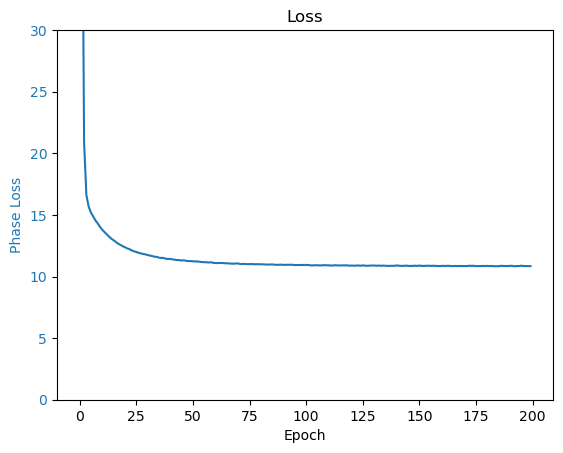

In [38]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_energy_model_vals = [metrics[e]['free_energy_model'] for e in epochs]
free_energy_data_vals = [metrics[e]['free_energy_data'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
# y range is 15 to 30
ax1.set_ylim(0, 30)

#ax2 = ax1.twinx()
#ax2.spines["right"].set_position(("axes", 1.05))
#ax2.plot(epochs, free_energy_model_vals, label="Free Energy Model", color="tab:orange")
#ax2.set_ylabel("Free Energy Model", color="tab:orange")
#ax2.tick_params(axis="y", labelcolor="tab:orange")

#ax3 = ax1.twinx()
#ax3.spines["right"].set_position(("axes", 1.15))
#ax3.plot(epochs, free_energy_data_vals, label="Free Energy Data", color="tab:green")
#ax3.set_ylabel("Free Energy Data", color="tab:green")
#ax3.tick_params(axis="y", labelcolor="tab:green")

plt.title("Loss")
plt.show()